## List of tables:

### 1. [Table 4: Treatment effects on quality](#quality)


#### Imports libraries

In [1]:
import matplotlib.pyplot as plt  # Plotting
import numpy as np  # Matrix algebra
import os  # File system handling
import pandas as pd  # Dataframe handling
import statsmodels.formula.api as smf  # Regressions analysis

from linearmodels.panel import RandomEffects  # Panel analysis
from linearmodels.panel.results import PanelModelComparison
from statsmodels.iolib.summary2 import summary_col  # Regression output table
from matplotlib.ticker import FuncFormatter  # Formating graphs

#### Set project directory

In [2]:
PROJECT_FOLDER = os.path.dirname(os.path.dirname(os.getcwd()))
FINAL_DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data', 'final')
TABLES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'tables')
FIGURES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'figures')

#### Pandas options

In [3]:
pd.set_option("display.precision", 3)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows", 40)

#### Set plotting style

In [4]:
plt.style.use('classic')

#### Set plotting properties 

In [5]:
bar_kw = dict(kind='bar', color='0.4', alpha=0.8, lw=0.5, width=0.7)
line_kw = dict(kind='line', lw=1, alpha=1, legend=True)
font_kw = dict(fontsize=11, color='k')
grid_kw = dict(linewidth=1, axis="y", zorder=2, antialiased=True)
xlab_kw = dict(fontsize=11, labelpad=3)
ylab_kw = dict(fontsize=11, labelpad=3)
error_kw = dict(elinewidth=2, ecolor='0.15')
legend_kw = dict(frameon=False)
tick_kw = dict(
    size=5,
    which='both',
    direction='out',
    right=False,
    top=False,
    labelbottom=True
)

#### Retrieving dataframe

In [6]:
DATA = os.path.join(
    FINAL_DATA_FOLDER, 
    'experiment_1',                
    'data_final.feather'
)

df = pd.read_feather(DATA)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Columns: 443 entries, Age to Q80_timer
dtypes: float64(225), int64(26), object(192)
memory usage: 10.4+ MB


#### Seperate quality concern-treatments from the following main analysys

In [7]:
sel = (df['Dataset'] == 'Main')
df = df[sel]

#### Reshape dataframe for panel analysis 

In [8]:
columns_to_keep = df.columns[[0, 12, 14, 16, 18, 23, 24, 25, 26, 28, 30, 32, 33, 34, 40]]
columns_to_melt = [f'Q{x}_editratio' for x in range(1, df['Counter'].max() + 1)]

df_melted = pd.melt(
    df, 
    id_vars=columns_to_keep,
    value_vars = columns_to_melt,
    var_name='Question_number',
    value_name='Edit_ratio'
)

df_melted = df_melted.dropna(axis=0, how='any', subset=['Edit_ratio'])
df_melted['Question_number'] = df_melted['Question_number'].str.extract(r'(\d+)').astype(int)
df_melted['Edit_ratio'] = df_melted['Edit_ratio'].astype(float)

df_panel = df_melted.set_index(['Id', 'Question_number'])
df_panel = df_panel.sort_index()
df_panel.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 62026 entries, (0, 1) to (3093, 11)
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    62026 non-null  float64
 1   Education              62026 non-null  int64  
 2   Female                 62026 non-null  int64  
 3   High_piece_rate        62026 non-null  int64  
 4   Latin_med              62026 non-null  int64  
 5   Leadership_technique   62026 non-null  object 
 6   Low_piece_rate         62026 non-null  int64  
 7   Mobile_device          62026 non-null  int64  
 8   No_intervention_timer  21219 non-null  float64
 9   No_piece_rate          62026 non-null  int64  
 10  Performance_pay        62026 non-null  object 
 11  Praise                 62026 non-null  int64  
 12  Reference_point        62026 non-null  int64  
 13  Treatment_str          62026 non-null  object 
 14  Edit_ratio             62026 non-null  float

#### Table 4: Treatment effects on quality <a id='quality'></a> 

In [9]:
regs = {}
regs['re1'] = 'Edit_ratio ~ 1 + Low_piece_rate + High_piece_rate + Praise + Reference_point'
regs['re2'] = 'Edit_ratio ~ 1 + (Low_piece_rate + High_piece_rate) * (Praise + Reference_point)'
regs['re3'] = regs['re2'] + ' + Age + Female + Education + Mobile_device + Latin_med'

re_results = [
    RandomEffects.from_formula(formula=v, data=df_panel).fit(cov_type='robust') 
    for v in regs.values()
]

re_qual = PanelModelComparison(re_results, precision='std_errors', stars=True)

path = os.path.join(
    TABLES_FOLDER, 
    'experiment_1',
    're_quality.tex'
)

with open(path, "w") as latex:
   latex.write(re_qual.summary.as_latex())

re_qual

,Model 0,Model 1,Model 2
Dep. Variable,Edit_ratio,Edit_ratio,Edit_ratio
Estimator,RandomEffects,RandomEffects,RandomEffects
No. Observations,62026,62026,62026
Cov. Est.,Robust,Robust,Robust
R-squared,0.0019,0.0020,0.0024
R-Squared (Within),0.0000,0.0000,0.0000
R-Squared (Between),0.0013,0.0031,0.0135
R-Squared (Overall),-0.0019,-0.0018,0.0011
F-statistic,29.747,15.444,11.623
P-value (F-stat),0.0000,0.0000,0.0000


#### Plot average error rate for all fragments by treatment

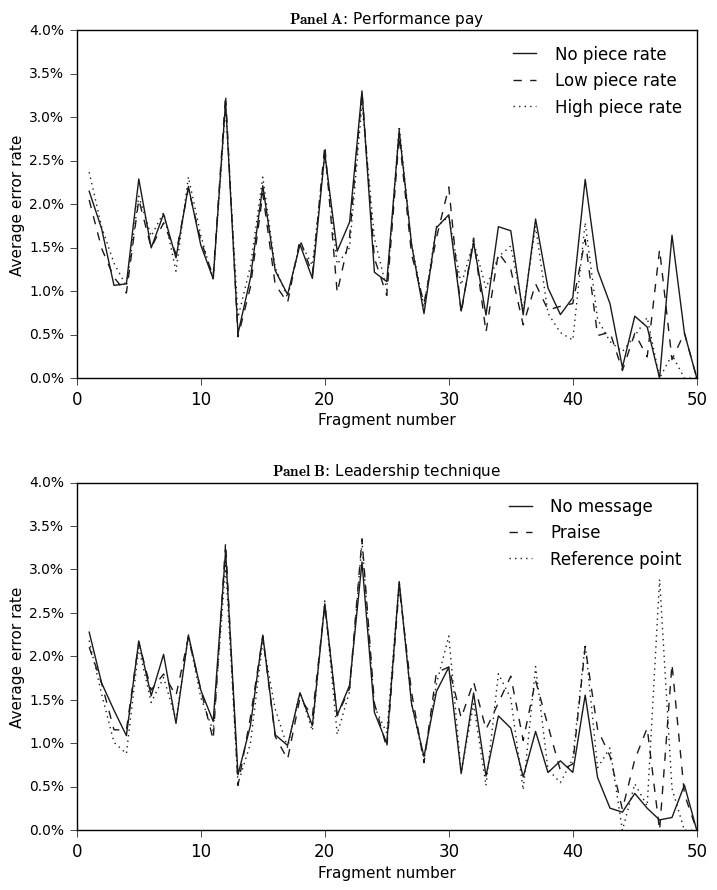

In [10]:
df_edit_ratio_first = df_panel\
    .groupby(['Performance_pay', 'Question_number'])\
    ['Edit_ratio']\
    .mean()\
    .unstack(level=0)\
    .sort_index(ascending=False, axis=1)

df_edit_ratio_second = df_panel\
    .groupby(['Leadership_technique', 'Question_number'])\
    ['Edit_ratio']\
    .mean()\
    .unstack(level=0)\

fig, axes = plt.subplots(nrows=2, figsize=(8, 10), dpi=100, facecolor='w')
fig.subplots_adjust(hspace=0.30)
axes[0].set_title('$\mathbf{Panel \ A}$: Performance pay', **font_kw)
axes[1].set_title('$\mathbf{Panel \ B}$: Leadership technique', **font_kw)
df_edit_ratio_first.plot(ax=axes[0], color='0.1', style=['-', '--',  ':'])
df_edit_ratio_second.plot(ax=axes[1], color='0.1', style=['-', '--', ':'])
for ax in axes:
    ax.tick_params(axis='x', **tick_kw)
    ax.tick_params(axis='y', labelsize='small', **tick_kw)
    ax.set_xlabel("Fragment number", **xlab_kw)
    ax.set_ylabel("Average error rate", **ylab_kw)
    ax.set_ylim(0.0, .04) 
    ax.set_xlim(0.0, 50)
    ax.legend(frameon=False, fontsize='medium') 
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

path = os.path.join(
    FIGURES_FOLDER, 
    'experiment_1',
    'error_rate.pdf'
)    
fig.savefig(path, bbox_inches='tight')

#### Calculate the time averaged error score and merge resuts with cross-sectional dataframe

In [11]:
avg_edit_ratio = df_panel['Edit_ratio'].mean(level=0).to_frame(name='Avg_edit_ratio')
df = df.merge(avg_edit_ratio, left_on='Id', right_on='Id', validate='one_to_one')

#### Histogram of average edit ratios, by treatment

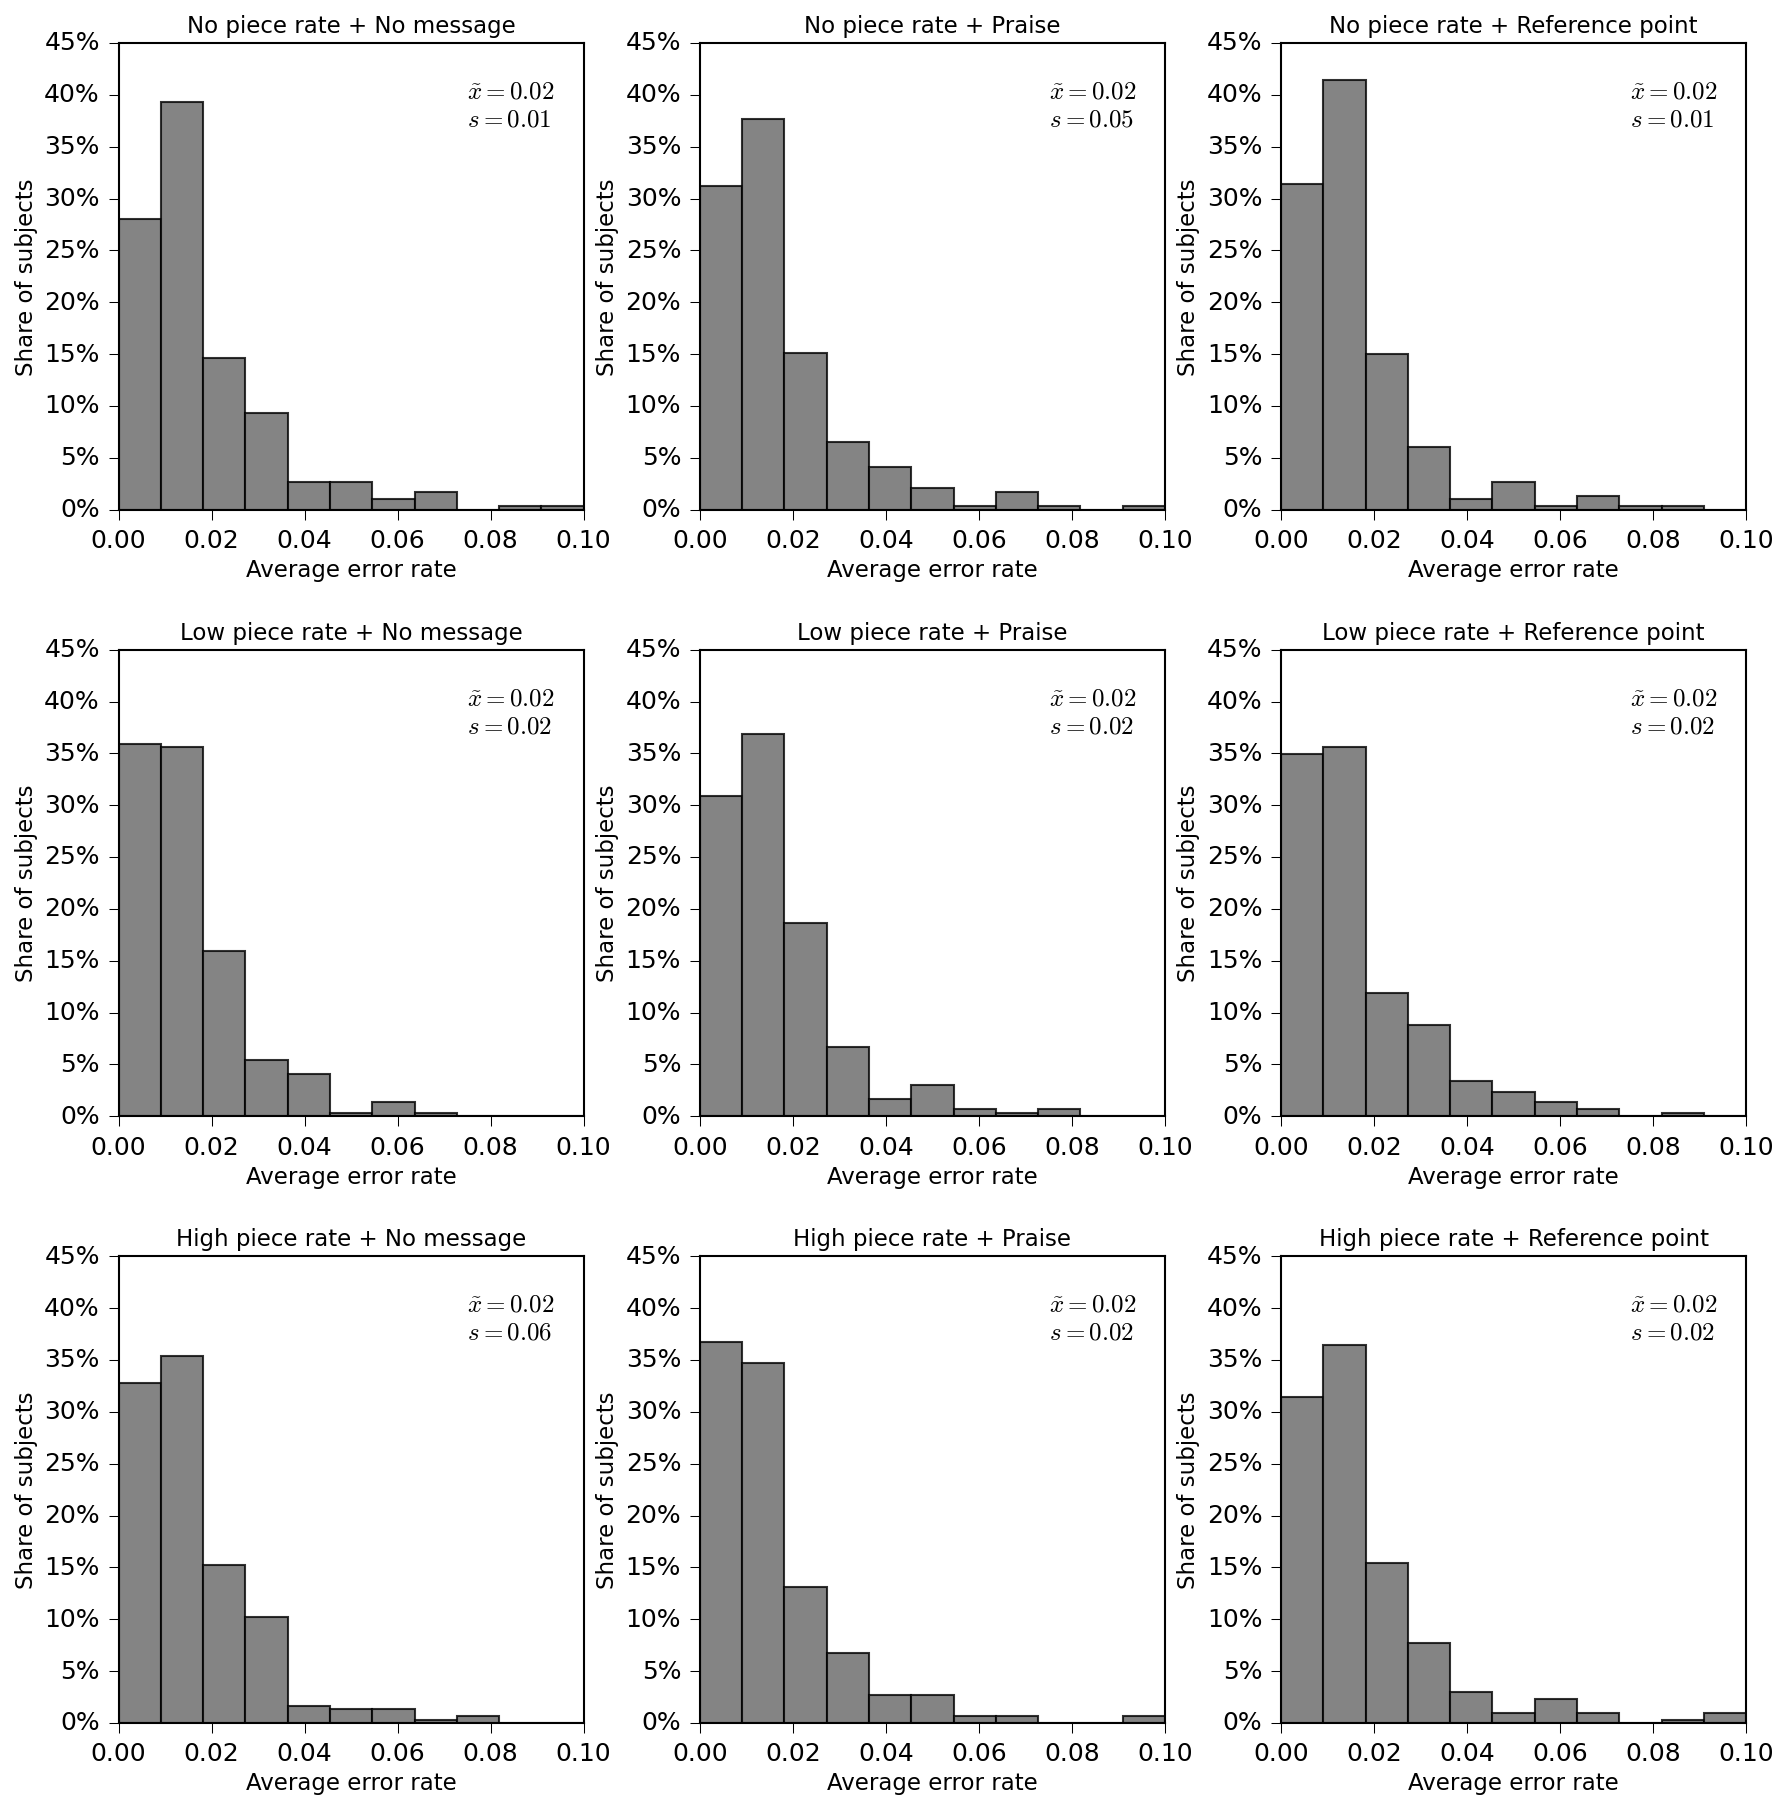

In [12]:
treat_index = [
    'No piece rate + No message',
    'No piece rate + Praise',
    'No piece rate + Reference point',
    'Low piece rate + No message',
    'Low piece rate + Praise',
    'Low piece rate + Reference point',
    'High piece rate + No message',
    'High piece rate + Praise',
    'High piece rate + Reference point',
]

hist_kw = dict(bins=11, range=(0, 0.1), color='0.4', alpha=0.8, grid=False)
fig, axis = plt.subplots(ncols=3, nrows=3, figsize=(14, 14), dpi=150)
fig.set_facecolor('w')
fig.subplots_adjust(hspace=0.3, wspace=0.25)
for i, ax in enumerate(fig.axes):     
    df_hist = df[df['Treatment_str'] == treat_index[i]]['Avg_edit_ratio']
    df_hist.hist(ax=ax, weights=np.ones(len(df_hist)) / len(df_hist), **hist_kw)
    ax.set_ylim(0, 0.45)
    ax.set_title(treat_index[i].replace('Neutral', 'No message'), **font_kw)
    ax.set_xlabel("Average error rate", **xlab_kw)
    ax.set_ylabel("Share of subjects", **ylab_kw)
    ax.tick_params(**tick_kw)
    ax.yaxis.set_major_formatter(FuncFormatter('{:.0%}'.format))
    mean, std = df_hist.mean(), df_hist.std()
    ax.text(0.075, 0.37 , f'$\~{{x}}={mean:.2f}$\n$s={std:.2f}$')

path = os.path.join(
    FIGURES_FOLDER, 
    'experiment_1',
    'edit_ratio_hist.pdf'
)    
fig.savefig(path, bbox_inches='tight')

#### Treatment effects on quality using pooled OLS <a id='quality_ols'></a> 

In [13]:
regs = {}
regs['re1'] = 'Avg_edit_ratio ~ 1 + Low_piece_rate + High_piece_rate'
regs['re2'] = 'Avg_edit_ratio ~ 1 + Praise + Reference_point'
regs['re3'] = 'Avg_edit_ratio ~ 1 + (Low_piece_rate + High_piece_rate) * (Praise + Reference_point)'
regs['re4'] = regs['re3'] + ' + Age + Female + Education + Mobile_device + Latin_med'
 
ols_results = [smf.ols(formula=v, data=df).fit(cov_type='HC1') for v in regs.values()]

order = [
    'Low_piece_rate',
    'High_piece_rate',
    'Praise',
    'Reference_point',
    'Low_piece_rate:Praise',
    'High_piece_rate:Praise',
    'Low_piece_rate:Reference_point',
    'High_piece_rate:Reference_point',
    'Age',
    'Female',
    'Education',
    'Mobile_device',
    'Latin_med',
    'Intercept',
]

auxiliary = {
    'N': lambda x: f'{x.nobs:.0f}',
    'F': lambda x: f'{x.fvalue:.3f}', 
    'P(>F)': lambda x: f'{x.f_pvalue:.3f}',
}

ols_qual = summary_col(
    ols_results, 
    stars=True, 
    info_dict=auxiliary, 
    float_format='%.3f', 
    regressor_order=order
)
ols_qual = ols_qual\
    .tables[0]\
    .rename(mapper=lambda x: x.replace('_', ' ').replace(':', ' * ').capitalize(), axis=0)\
    .rename(mapper=lambda x: x.capitalize().split()[0].replace('_', ' '), axis=1)\
    .rename({'Avg edit ratio': 'Error rate'}, axis=1)\
    .rename({'Latin med': 'Latin'}, axis=0)\
    .rename_axis('Dependent variable:', axis=1)

path = os.path.join(
    TABLES_FOLDER, 
    'experiment_1',
    'ols_quality.tex'
)
ols_qual.to_latex(
    path, 
    bold_rows=True, 
    float_format="%.3f"
)
    
ols_qual

Dependent variable:,Error rate,Error rate,Error rate,Error rate
Low piece rate,-0.001,,-0.001,-0.001
,(0.001),,(0.001),(0.001)
High piece rate,0.001,,0.004,0.004
,(0.002),,(0.004),(0.004)
Praise,,-0.000,0.002,0.003
,,(0.002),(0.003),(0.003)
Reference point,,-0.001,-0.001,-0.001
,,(0.001),(0.001),(0.001)
Low piece rate * praise,,,-0.002,-0.002
,,,(0.003),(0.003)


In [14]:
!jupyter nbconvert --output-dir='./docs' --to html 5_treatment_effects_quality.ipynb

[NbConvertApp] Converting notebook 5_treatment_effects_quality.ipynb to html
[NbConvertApp] Writing 1065407 bytes to docs/5_treatment_effects_quality.html
